# Telecom X — Churn de Clientes (ETL, EDA e Modelagem)
Este caderno executa o **pipeline completo** para análise de evasão de clientes:
1) **ETL** (extração do JSON, limpeza e transformação)  
2) **EDA** (exploração + visualizações)  
3) **Modelagem preditiva** (baselines)  
4) **Recomendações de negócio**  
5) **Esqueleto para ingestão via API**

> Dados: arquivo `TelecomX_Data.json` (estrutura aninhada `customer/phone/internet/account`). Ajuste `DATA_PATH` se necessário.


In [1]:
# === Imports e Configurações ===
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Para exibir mais colunas/linhas em visões de DataFrame
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

In [2]:
# === EXTRAÇÃO ===
# Leitura **fixa** direto da URL crua do GitHub
RAW_URL = "https://raw.githubusercontent.com/Leylane/TelecomX_BR/refs/heads/main/dataset/TelecomX_Data.json"

import requests

def load_json_any_text(txt: str):
    txt = txt.strip()
    try:
        return json.loads(txt)
    except json.JSONDecodeError:
        data = []
        for line in txt.splitlines():
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
        return data

r = requests.get(RAW_URL, timeout=60)
r.raise_for_status()
raw_data = load_json_any_text(r.text)

df_raw = pd.json_normalize(raw_data, sep="_")
print("Formato bruto:", df_raw.shape)
df_raw.head()

Formato bruto: (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [3]:
# === TRANSFORMAÇÃO / LIMPEZA ===
df = df_raw.copy()

# Conversões numéricas (se existirem)
for col in ["account_Charges_Monthly", "account_Charges_Total", "customer_tenure", "customer_SeniorCitizen"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Normaliza 'No internet service' / 'No phone service' -> 'No'
def normalize_service_nos(df_in: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()
    repl = {"No internet service": "No", "No phone service": "No"}
    for c in df_out.columns:
        if df_out[c].dtype == "object":
            df_out[c] = df_out[c].replace(repl)
    return df_out

df = normalize_service_nos(df)

# Features derivadas
df["HasInternet"] = np.where(df.get("internet_InternetService", "No").ne("No"), 1, 0).astype(int)
df["HasPhone"] = np.where(df.get("phone_PhoneService", "No").eq("Yes"), 1, 0).astype(int)

# Rótulo de churn
df["Churn"] = df["Churn"].fillna("").astype(str).str.strip()
df_valid = df[df["Churn"].isin(["Yes", "No"])].copy()

# Faixas de tenure (se existir)
if "customer_tenure" in df_valid.columns:
    bins = [0, 6, 12, 24, 48, 72, np.inf]
    labels = ["0-6", "7-12", "13-24", "25-48", "49-72", "72+"]
    df_valid["tenure_bin"] = pd.cut(df_valid["customer_tenure"], bins=bins, labels=labels, right=True, include_lowest=True)

print("Após limpeza/seleção:", df_valid.shape)
df_valid.head()

Após limpeza/seleção: (7043, 24)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,HasInternet,HasPhone,tenure_bin
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,1,1,7-12
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1,1,7-12
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,1,0-6
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1,1,13-24
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1,1,0-6


In [4]:
# === EDA — Tabelas de Taxa de Churn ===
df_valid["churn_flag"] = (df_valid["Churn"] == "Yes").astype(int)

def rate_by(df_in, col):
    g = (
        df_in.groupby(col)["churn_flag"]
        .agg(["count", "sum", "mean"])
        .rename(columns={"count": "n", "sum": "churned", "mean": "churn_rate"})
        .sort_values("churn_rate", ascending=False)
    )
    return g

overall_churn = df_valid["churn_flag"].mean()
print(f"Taxa de churn global: {overall_churn:.2%}")

tbls = {}
for col in ["account_Contract", "account_PaymentMethod", "internet_InternetService", "internet_OnlineSecurity", "internet_TechSupport", "tenure_bin"]:
    if col in df_valid.columns:
        tbls[col] = rate_by(df_valid, col)
        display(tbls[col].head(10))

Taxa de churn global: 26.54%


,n,churned,churn_rate
account_Contract,,,
Month-to-month,3875,1655,0.427097
One year,1473,166,0.112695
Two year,1695,48,0.028319


,n,churned,churn_rate
account_PaymentMethod,,,
Electronic check,2365,1071,0.452854
Mailed check,1612,308,0.191067
Bank transfer (automatic),1544,258,0.167098
Credit card (automatic),1522,232,0.152431


,n,churned,churn_rate
internet_InternetService,,,
Fiber optic,3096,1297,0.418928
DSL,2421,459,0.189591
No,1526,113,0.074050


,n,churned,churn_rate
internet_OnlineSecurity,,,
No,5024,1574,0.313296
Yes,2019,295,0.146112


,n,churned,churn_rate
internet_TechSupport,,,
No,4999,1559,0.311862
Yes,2044,310,0.151663


/tmp/ipython-input-3849946530.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_in.groupby(col)["churn_flag"]


,n,churned,churn_rate
tenure_bin,,,
0-6,1481,784,0.529372
7-12,705,253,0.358865
13-24,1024,294,0.287109
25-48,1594,325,0.203890
49-72,2239,213,0.095132
72+,0,0,NaN


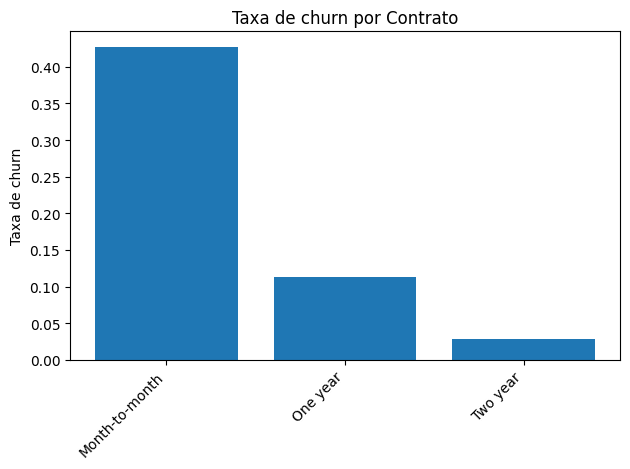

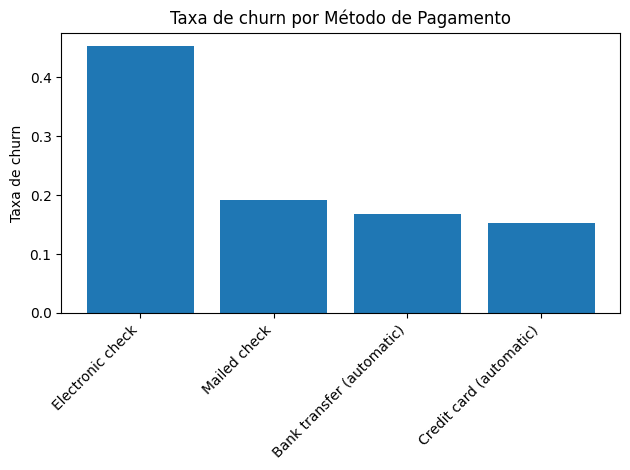

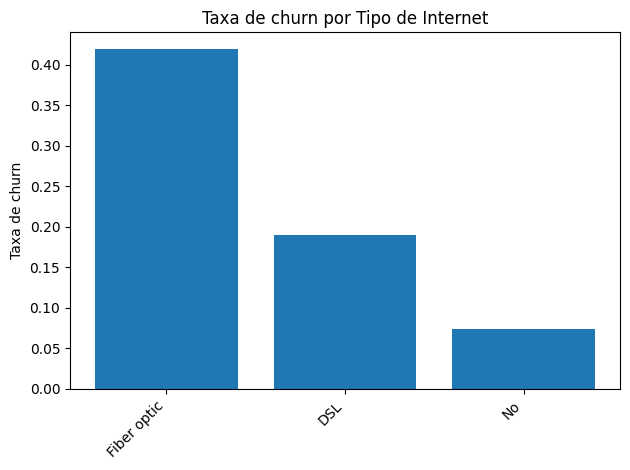

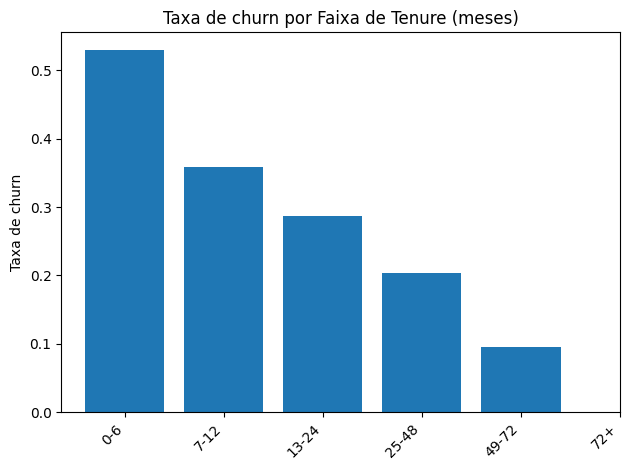

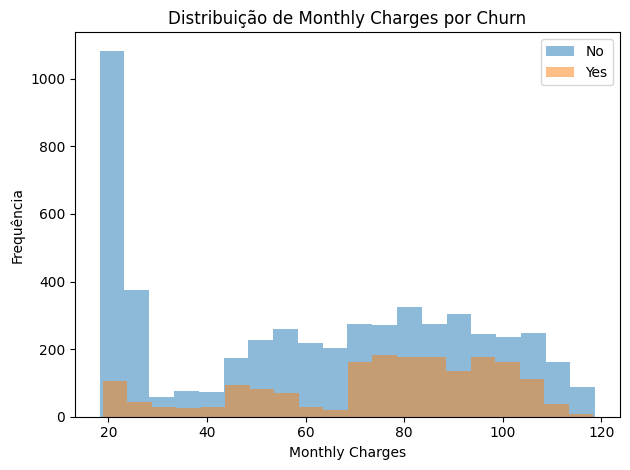

In [5]:
# === EDA — Visualizações (Matplotlib) ===
def plot_bar_from_group(df_group, title):
    if df_group is None or df_group.empty:
        return
    plt.figure()
    x = np.arange(len(df_group.index))
    vals = df_group["churn_rate"].values
    labels_local = [str(i) for i in df_group.index]
    plt.bar(x, vals)  # sem cores customizadas
    plt.xticks(x, labels_local, rotation=45, ha="right")
    plt.ylabel("Taxa de churn")
    plt.title(title)
    plt.tight_layout()
    plt.show()

if "account_Contract" in tbls:
    plot_bar_from_group(tbls["account_Contract"], "Taxa de churn por Contrato")
if "account_PaymentMethod" in tbls:
    plot_bar_from_group(tbls["account_PaymentMethod"], "Taxa de churn por Método de Pagamento")
if "internet_InternetService" in tbls:
    plot_bar_from_group(tbls["internet_InternetService"], "Taxa de churn por Tipo de Internet")
if "tenure_bin" in tbls:
    plot_bar_from_group(tbls["tenure_bin"], "Taxa de churn por Faixa de Tenure (meses)")

# Distribuição de Monthly Charges por churn
if "account_Charges_Monthly" in df_valid.columns:
    plt.figure()
    for label in ["No", "Yes"]:
        subset = df_valid.loc[df_valid["Churn"] == label, "account_Charges_Monthly"].dropna()
        plt.hist(subset, bins=20, alpha=0.5, label=label)
    plt.xlabel("Monthly Charges")
    plt.ylabel("Frequência")
    plt.title("Distribuição de Monthly Charges por Churn")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
# === DATASET LIMPO para Modelagem ===
cols_keep = [
    "Churn",
    "customer_gender",
    "customer_SeniorCitizen",
    "customer_Partner",
    "customer_Dependents",
    "customer_tenure",
    "phone_PhoneService",
    "phone_MultipleLines",
    "internet_InternetService",
    "internet_OnlineSecurity",
    "internet_OnlineBackup",
    "internet_DeviceProtection",
    "internet_TechSupport",
    "internet_StreamingTV",
    "internet_StreamingMovies",
    "account_Contract",
    "account_PaperlessBilling",
    "account_PaymentMethod",
    "account_Charges_Monthly",
    "account_Charges_Total",
    "HasInternet",
    "HasPhone",
    "tenure_bin"
]
cols_keep = [c for c in cols_keep if c in df_valid.columns]
df_clean = df_valid[cols_keep].copy()

print("Dataset limpo pronto para modelagem:", df_clean.shape)
df_clean.head()


Dataset limpo pronto para modelagem: (7043, 23)


,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,HasInternet,HasPhone,tenure_bin
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,1,1,7-12
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1,1,7-12
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,1,0-6
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1,1,13-24
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1,1,0-6


In [7]:
# === MODELAGEM (Baselines, versão simples) ===
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Garante df_clean
if 'df_clean' not in globals():
    cols_keep = [c for c in [
        "Churn","customer_gender","customer_SeniorCitizen","customer_Partner","customer_Dependents",
        "customer_tenure","phone_PhoneService","phone_MultipleLines","internet_InternetService",
        "internet_OnlineSecurity","internet_OnlineBackup","internet_DeviceProtection","internet_TechSupport",
        "internet_StreamingTV","internet_StreamingMovies","account_Contract","account_PaperlessBilling",
        "account_PaymentMethod","account_Charges_Monthly","account_Charges_Total","HasInternet","HasPhone","tenure_bin"
    ] if c in df_valid.columns]
    df_clean = df_valid[cols_keep].copy()

# Define numéricas e categóricas de forma segura
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols + ["Churn"]]

# Imputação simples
for c in cat_cols:
    df_clean[c] = df_clean[c].astype("object").fillna("Unknown")
for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

# Alvo e features
df_model = df_clean[df_clean["Churn"].isin(["Yes", "No"])].copy()
y = (df_model["Churn"] == "Yes").astype(int)
X = pd.get_dummies(df_model.drop(columns=["Churn"]), drop_first=True)

# Holdout estratificado 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def eval_model(clf, name):
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    pred = (proba >= 0.5).astype(int)
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, proba),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "pred": pred,
        "proba": proba,
        "clf": clf
    }

# Modelos simples
lr = LogisticRegression(max_iter=2000, solver="liblinear")  # solver estável p/ binário
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)

res_lr = eval_model(lr, "LogisticRegression")
res_rf = eval_model(rf, "RandomForest")

# Tabela compacta de métricas
metrics_df = pd.DataFrame([
    {k: v for k, v in res_lr.items() if k in ["Model","ROC_AUC","Accuracy","Precision","Recall"]},
    {k: v for k, v in res_rf.items() if k in ["Model","ROC_AUC","Accuracy","Precision","Recall"]},
]).set_index("Model").round(3)

display(metrics_df)

# Top-10 fatores mais relevantes
# LR: coeficientes (|coef|)
lr_coef = pd.Series(res_lr["clf"].coef_[0], index=X.columns)
top_lr = lr_coef.abs().sort_values(ascending=False).head(10)
top_lr_df = pd.DataFrame({"feature": top_lr.index, "abs_coef": top_lr.values})
top_lr_df.index = range(1, len(top_lr_df)+1)

# RF: importâncias
rf_imp = pd.Series(res_rf["clf"].feature_importances_, index=X.columns)
top_rf = rf_imp.sort_values(ascending=False).head(10)
top_rf_df = pd.DataFrame({"feature": top_rf.index, "importance": top_rf.values})
top_rf_df.index = range(1, len(top_rf_df)+1)

print("\nTop 10 — Logistic Regression (|coef|):")
display(top_lr_df)

print("\nTop 10 — Random Forest (importance):")
display(top_rf_df)


,ROC_AUC,Accuracy,Precision,Recall
Model,,,,
LogisticRegression,0.846,0.796,0.643,0.516
RandomForest,0.823,0.784,0.625,0.460



Top 10 — Logistic Regression (|coef|):


,feature,abs_coef
1,account_Contract_Two year,0.748354
2,internet_TechSupport_Yes,0.574551
3,account_Contract_One year,0.466352
4,internet_OnlineSecurity_Yes,0.437245
5,HasPhone,0.432151
6,phone_PhoneService_Yes,0.432151
7,account_PaperlessBilling_Yes,0.431190
8,internet_InternetService_Fiber optic,0.427909
9,tenure_bin_13-24,0.411585
10,internet_InternetService_No,0.400937



Top 10 — Random Forest (importance):


,feature,importance
1,account_Charges_Total,0.164992
2,account_Charges_Monthly,0.152422
3,customer_tenure,0.146139
4,account_Contract_Two year,0.059578
5,internet_InternetService_Fiber optic,0.046742
6,account_PaymentMethod_Electronic check,0.039626
7,account_Contract_One year,0.029909
8,tenure_bin_49-72,0.027409
9,customer_gender_Male,0.025213
10,account_PaperlessBilling_Yes,0.025089


from matplotlib import pyplot as plt
top_rf_df['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
top_rf_df['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

## Recomendações de Negócio (anti-churn)
1. **Contrato mensal (Month-to-month)**: ofertas de *upgrade* com desconto para 12–24 meses no onboarding (até 90 dias).  
2. **Pagamento**: migrar clientes de *Electronic check* para débito/crédito automático com incentivo e UX simplificada.  
3. **Bundles de suporte/segurança**: incluir **TechSupport** e **OnlineSecurity** em pacotes de entrada.  
4. **Onboarding estendido (0–90 dias)**: contato proativo, tutoriais e SLA rápido de atendimento.  
5. **Revisão de pacotes em alta fatura mensal**: adequar preço/valor percebido (streaming, proteção, backup).  
6. **Alertas preditivos**: usar o *score* para priorizar retenção.  
7. **Testes A/B**: medir impacto real de bundles, mensagens e descontos em churn/LTV.


## Ingestão via API — Esqueleto (paginação + rate limit)
Abaixo um exemplo de função para **substituir a leitura de JSON local por uma API REST** paginada.


In [8]:
import requests
from time import sleep

def fetch_api(base_url, token, page_param="page", per_page=100, max_pages=1000, backoff=1.0):
    """
    Exemplo de ingestão paginada.
    - base_url: endpoint (e.g., https://api.telecomx.com/v1/customers)
    - token: Bearer token
    - page_param: nome do parâmetro de página
    - per_page: itens por página
    - max_pages: sanidade para não loopar
    - backoff: backoff exponencial para 429
    """
    headers = {"Authorization": f"Bearer {token}"}
    page = 1
    rows = []
    while page <= max_pages:
        params = {page_param: page, "per_page": per_page}
        r = requests.get(base_url, headers=headers, params=params, timeout=30)
        if r.status_code == 429:  # rate limit
            sleep(backoff); backoff = min(backoff * 2, 60); continue
        r.raise_for_status()
        data = r.json()
        if not data:
            break
        if isinstance(data, list):
            rows.extend(data)
        else:
            rows.extend(data.get("items", []))
        if len(data) < per_page if isinstance(data, list) else len(data.get("items", [])) < per_page:
            break
        page += 1
    df_api = pd.json_normalize(rows, sep="_")
    return df_api

# Exemplo de uso (comentado):
# df_from_api = fetch_api("https://api.telecomx.com/v1/customers", token="SEU_TOKEN")
# df_from_api.head()